Want to understand difference between computing number of successes and failures separate vs treating them as one blob.

Is there something that approximately holds? It appears so.

Background is roughly to do with computing likelihood of binomial data given Beta prior on probability $q$ of success:

$$ P(Y|\alpha, \beta) = ... = \frac{B(\alpha + s, \beta + f)}{B(\alpha, \beta)} $$

Problem is, that the integration in the ... means that you need to worry about interaction between samples (i.e. success > 1) which makes doing the usual optimization of cost function more tricky. However, it seems like if there are few collisions (same parts of feature space) and succ/failure almost always 0 or 1 ... then the approximation is closish. So you might try to use a likelihood like

$$ \prod_i \frac{1}{B(\alpha, \beta)}B(\alpha+1, \beta)^{Y_i}B(\alpha, \beta+1)^{1 - Y_i} $$

where $\alpha = \alpha(X_i), \beta = \beta(X_i)$

Gradients (WRONG TODO FIX):

Use $\partial_x \ln B(x, y) = \Psi(x) - \Psi(x+y)$ where $\Psi$ is digamma

$$ \partial_{\alpha}J_i = Y_i (\alpha - 1) \Psi_{\alpha} + (1 - \alpha - \beta) \Psi_{\alpha+\beta} $$

$$ \partial_{\beta}J_i = (1 - Y_i)(1-\beta) \Psi_{\beta} + (1 - \alpha - \beta)\Psi_{\alpha+\beta} $$

$$ \Psi(a) = \Gamma'(a) / \Gamma(a) $$

In [13]:
from scipy.special import beta

In [14]:
x = linspace(1, 10) # range for alpha and beta

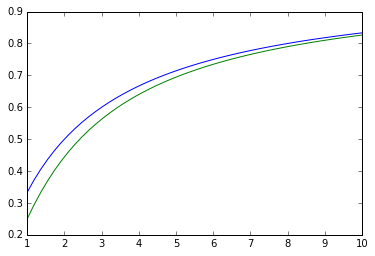

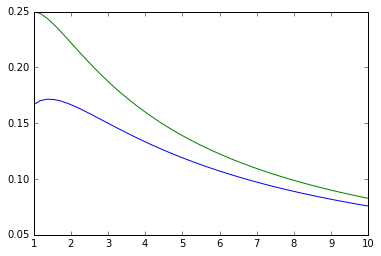

In [15]:
%matplotlib inline
n = 2
beta0 = 1
for i in range(n):
    succ = n - i
    fail = i
    f = lambda a, b: beta(a + succ, b + fail) / beta(a, b) # exact
    g = lambda a, b: (beta(a + 1, b) ** succ) * (beta(a, b + 1) ** fail) / (beta(a, b) ** (succ + fail)) # 'approx'
    fy = f(x, beta0)
    gy = g(x, beta0)
    figure(i)
    clf()
    plot(x, fy)
    plot(x, gy)
    

(30,) (30,)


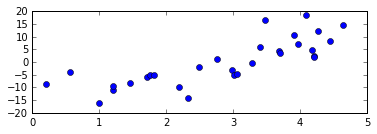

In [91]:
%matplotlib inline
# does this make any sense at all?
from scipy.special import betaln, polygamma

def psi(x):
    return polygamma(0, x)

def dpsi(x):
    return polygamma(1, x)

def J(alpha, beta, Y):
    out = Y * betaln(alpha + 1, beta) + (1 - Y) * betaln(alpha, beta + 1) - betaln(alpha, beta) * len(Y)
    return out.sum()
    
def dJ(alpha, beta, Y):
    # dJalpha = Y * (alpha - 1) * psi(alpha) + (1 - alpha - beta) * psi(alpha + beta)
    # dJbeta = (1 - Y) * (1 - beta) * psi(beta) + (1 - alpha - beta) * psi(alpha + beta)
    m = len(Y)
    dJalpha = Y * psi(alpha + 1) + (m - 1) * psi(alpha + beta + 1) + (1 - Y - m) * psi(alpha) + m * psi(alpha + beta)
    dJbeta = (Y - m) * psi(beta) - psi(alpha + beta + 1) + (1 - Y) * psi(beta + 1) + m * psi(alpha + beta)
    return dJalpha, dJbeta

from pylab import *
m = 30
n = 1
X = zeros((m, n))
x = 5 * rand(m)
x.sort()
X[:,0] = x
f = lambda x: x ** 2
y_latent = (f(X) + 5 * randn(m, n)).sum(axis=1)
y_latent = y_latent - y_latent.mean()
y = (y_latent > 0).astype(float)
ion()
figure(1)
clf()
subplot(211)
plot(x, y_latent, 'o')

print(x.shape, y.shape)

In [117]:
def _J(a, Y=y):
    n = int(len(a) / 2)
    return J(a[:n], a[n:], Y)

def _dJ(a, Y=y):
    n = int(len(a) / 2)
    return np.hstack(dJ(a[:n], a[n:], Y))

import scipy.optimize as so
x0 = np.ones(y.shape[0] * 2)
print(x0.shape, y.shape)
out = so.fmin_l_bfgs_b(_J, x0, fprime=_dJ, maxiter=10000, disp=1, factr=10)

(60,) (30,)


In [134]:
n = int(len(out[0]) / 2)
a, b = out[0][:n], out[0][n:]

# look at scipy dist beta
import scipy.stats as ss
_b = ss.beta(a, b)

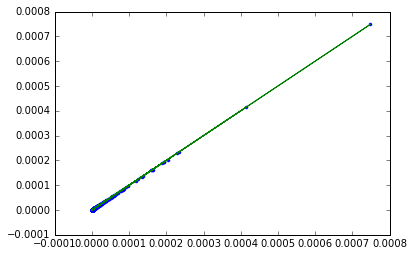

In [104]:
eps = 1e-8
out = []
for j in range(100):
    xx = rand(x0.shape[0])    
    for i in range(x0.shape[0]):
        dxx = np.zeros(xx.shape)
        dxx[i] = eps
        dxx = dxx / norm(dxx) * eps
        a = (_J(xx + dxx) - _J(xx))
        b = _dJ(xx).dot(dxx)
        out.append([a, b])
    
out = pd.DataFrame(out)

plot(out[0], out[1], '.')
plot(out[0], out[0], '-')

In [95]:
so.check_grad(_J, _dJ, rand(x0.shape[0])) / x0.shape[0]

1.1982664127396856

In [103]:
so.check_grad(lambda x: psi(x).sum(), dpsi, randn(100))

0.158604835767515

(100, 1) (100, 2)


TypeError: only length-1 arrays can be converted to Python scalars

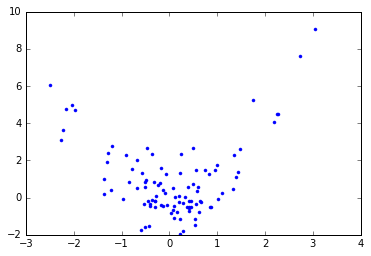

In [44]:
# can we just spoof the dim?
x = randn(100)
y = x ** 2 + randn(100)
plot(x, y, '.')
X = np.atleast_2d(x).T
Y = np.vstack([y, y]).T
import xgboost as xgb
klf = xgb.XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

print(X.shape, Y.shape)

klf.fit(X, Y, eval_set=[(X, Y)], early_stopping_rounds=40)

In [38]:
klf

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [37]:
from scipy.special import betaln, polygamma

def psi(x):
    return polygamma(0, x)

def dpsi(x):
    return polygamma(1, x)

def J(alpha, beta, Y):
    out = Y * betaln(alpha + 1, beta) + (1 - Y) * betaln(alpha, beta + 1) - betaln(alpha, beta)
    return out
    
def dJ(alpha, beta, Y):
    dJalpha = Y * (alpha - 1) * psi(alpha) + (1 - alpha - beta) * psi(alpha + beta)
    dJbeta = (1 - Y) * (1 - beta) * psi(beta) + (1 - alpha - beta) * psi(alpha + beta)
    return dJalpha, dJbeta

def logobj(preds, dtrain):
    Y = dtrain.get_label()
    n = len(Y) # number of samples
    alpha = preds[:,0]
    beta = preds[:,1]
    g = np.zeros(n, 2) # first order grad
    h = np.zeros(n, 2) # second order grad (diagonal of hessian)
    g[]

SyntaxError: invalid syntax (<ipython-input-37-5c02a9f81241>, line 25)

In [ ]:
# user define objective function, given prediction, return gradient and second order gradient
# this is loglikelihood loss
def logregobj(preds, dtrain):
    labels = dtrain.get_label()
    # preds will be alpha and beta
    
    #     preds = 1.0 / (1.0 + np.exp(-preds))
    #     grad = preds - labels
    #     hess = preds * (1.0-preds)
    return grad, hess